In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as ce
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
import shap
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


%matplotlib inline

In [2]:
#cleaned dataset
df = pd.read_csv("auto_data_cleaned_16_09_2024.csv", index_col = False)

# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['year', 'offer_description', ])

df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')
df

,brand,model,price_in_euro,power_ps,fuel_consumption_l_100km,mileage_in_km,age,Modell_encoded,Brand_encoded,fuel_type_CNG,...,color_brown,color_gold,color_green,color_grey,color_orange,color_red,color_silver,color_violet,color_white,color_yellow
0,alfa-romeo,Alfa Romeo GTV,1300.0,201.0,10.9,160500.0,29.0,18976.242694,30473.342627,0,...,0,0,0,0,0,1,0,0,0,0
1,alfa-romeo,Alfa Romeo Spider,4900.0,150.0,9.5,189500.0,29.0,11447.487664,30473.342627,0,...,0,0,0,0,0,0,0,0,0,0
2,alfa-romeo,Alfa Romeo 164,17950.0,179.0,7.2,96127.0,28.0,23728.532339,30473.342627,0,...,0,0,0,0,0,1,0,0,0,0
3,alfa-romeo,Alfa Romeo Spider,7900.0,150.0,9.5,47307.0,28.0,11447.487664,30473.342627,0,...,0,0,0,0,0,1,0,0,0,0
4,alfa-romeo,Alfa Romeo 145,3500.0,150.0,8.8,230000.0,28.0,22595.176338,30473.342627,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238297,volvo,Volvo XC40,57990.0,261.0,6.6,1229.0,1.0,35630.221298,35357.419339,0,...,0,0,0,0,0,0,0,0,1,0
238298,volvo,Volvo XC90,89690.0,235.0,7.6,4900.0,1.0,47785.948276,35357.419339,0,...,0,0,0,0,0,0,0,0,1,0
238299,volvo,Volvo V60,61521.0,197.0,4.7,1531.0,1.0,31898.819734,35357.419339,0,...,0,0,0,0,0,0,0,0,1,0
238300,volvo,Volvo XC40,57890.0,179.0,6.6,1500.0,1.0,35630.221298,35357.419339,0,...,0,0,0,0,0,0,0,0,1,0


In [3]:
#cleaned dropped dataset
df_drop = pd.read_csv("auto_data_cleaned_drop__15_10_2024.csv")


# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df_drop['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df_drop['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df_drop=df_drop.drop(columns=['year', 'offer_description'])

df_drop = pd.get_dummies(df_drop, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')
df_drop.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213668 entries, 0 to 213667
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   brand                             213668 non-null  object 
 1   model                             213668 non-null  object 
 2   price_in_euro                     213668 non-null  float64
 3   power_ps                          213668 non-null  float64
 4   fuel_consumption_l_100km          213668 non-null  float64
 5   mileage_in_km                     213668 non-null  float64
 6   age                               213668 non-null  float64
 7   Modell_encoded                    213668 non-null  float64
 8   Brand_encoded                     213668 non-null  float64
 9   fuel_type_CNG                     213668 non-null  int64  
 10  fuel_type_Diesel                  213668 non-null  int64  
 11  fuel_type_Diesel Hybrid           213668 non-null  i

In [4]:
# Splitting the data into training and test sets
X = df.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df['price_in_euro']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting the data into training and test sets
X_d = df_drop.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y_d = df_drop['price_in_euro']  # Target variable

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.2, random_state=42)


In [5]:
# Initialize the model with default parameters
xgb = XGBRegressor(n_estimators=200, max_depth=5)
# Train the model
xgb.fit(X_train, y_train)

#  Evaluate the model on the Test Set
y_pred = xgb.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f"Test MAE - full dataset: {test_mae}")
print(f"Test Set MSE - full dataset: {mse_test}")
print(f"Test R² - full dataset: {test_r2}")

# Initialize the model with default parameters
xgb_d = XGBRegressor(n_estimators=200, max_depth=5)
# Train the model
xgb_d.fit(X_train_d, y_train_d)

#  Evaluate the model on the Test Set
y_pred_d = xgb_d.predict(X_test_d)
test_mae_d = mean_absolute_error(y_test_d, y_pred_d)
test_r2_d = r2_score(y_test_d, y_pred_d)
mse_test_d = mean_squared_error(y_test_d, y_pred_d)

print(f"Test MAE - dropped dataset: {test_mae_d}")
print(f"Test Set MSE - drop dataset: {mse_test_d}")
print(f"Test R² - dropped dataset: {test_r2_d}")


Test MAE - full dataset: 3737.4357952171868
Test Set MSE - full dataset: 451016383.57099104
Test R² - full dataset: 0.6018683507823421
Test MAE - dropped dataset: 4159.141152438179
Test Set MSE - drop dataset: 181019789.5059302
Test R² - dropped dataset: 0.8141494594556136


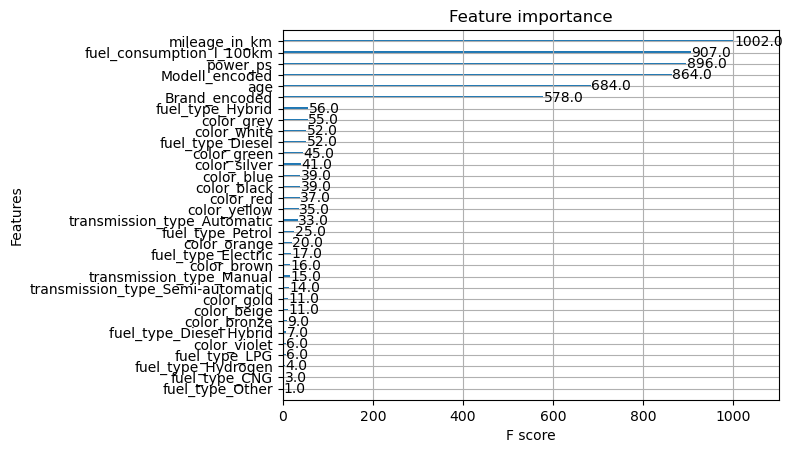

In [6]:
import xgboost as xgb
from xgboost import plot_importance


# Initialize and train the XGBRegressor
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=5)
xgb_model.fit(X_train, y_train)

# Plot feature importance
plot_importance(xgb_model)
plt.show()

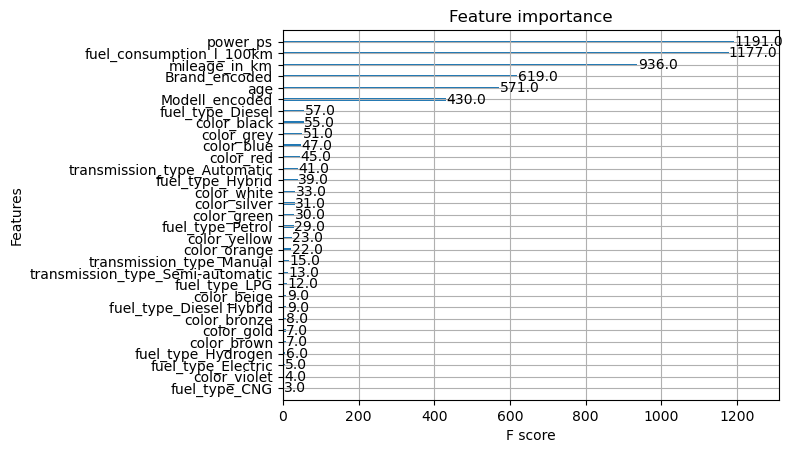

In [7]:
# Initialize and train the XGBRegressor
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=5)
xgb_model.fit(X_train_d, y_train_d)

# Plot feature importance
plot_importance(xgb_model)
plt.show()

### gridsearch CV of parameters

In [8]:
# Initialize the model with default parameters
xgb = XGBRegressor(n_estimators=200, max_depth=5)

# Define the grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 5, 10]
}


# Set up GridSearchCV with KNN Regressor and 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_xgb_regressor = grid_search.best_estimator_

# Predict using the best estimator
y_pred = best_xgb_regressor.predict(X_test)



# Calculate the R² score
r2 = r2_score(y_test, y_pred)

# Print the R² score
print(f"R² Score - Full data: {r2:.4f}")
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print(f"Test Set MSE - Full data: {mse_test}")
print(f"Test Set MAE - full data: {mae_test}")
print(f"Test RMSE: {rmse:.2f}")

Best Parameters: {'gamma': 0, 'learning_rate': 0.2, 'reg_alpha': 0, 'reg_lambda': 1}
R² Score - Full data: 0.6133
Test Set MSE - Full data: 438033588.03237563
Test Set MAE - full data: 3769.3927018241984
Test RMSE: 20929.25


In [9]:
# Initialize the model with default parameters
xgb = XGBRegressor(n_estimators=200, max_depth=5)

# Define the grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 5, 10]
}


# Set up GridSearchCV with KNN Regressor and 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
grid_search.fit(X_train_d, y_train_d)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_xgb_regressor = grid_search.best_estimator_

# Predict using the best estimator
y_pred = best_xgb_regressor.predict(X_test_d)



# Calculate the R² score
r2 = r2_score(y_test_d, y_pred)

# Print the R² score
print(f"R² Score - Dropped data: {r2:.4f}")
# Evaluate the model
mse = mean_squared_error(y_test_d, y_pred)
rmse = mse ** 0.5

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test_d, y_pred)
mae_test = mean_absolute_error(y_test_d, y_pred)
print(f"Test Set MSE - Dropped data: {mse_test}")
print(f"Test Set MAE - Dropped data: {mae_test}")
print(f"Test RMSE: {rmse:.2f}")

Best Parameters: {'gamma': 0, 'learning_rate': 0.2, 'reg_alpha': 0, 'reg_lambda': 1}
R² Score - Dropped data: 0.8194
Test Set MSE - Dropped data: 168968643.34727904
Test Set MAE - Dropped data: 4232.8896583481455
Test RMSE: 12998.79


### The results are acceptable, but removing of extreme values will increase precision

## Training on Dataset without Outliers:

In [3]:
#cleaned dataset
df = pd.read_csv("auto_data_cleaned_16_09_2024.csv")

# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['year',  'offer_description', ])

df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')

# Remove outliers using Z-score for price and mileage
df_clean = df[(np.abs(stats.zscore(df['price_in_euro'])) <10)]  # 4 is the higher threshold for outliers
df_clean = df_clean[(np.abs(stats.zscore(df_clean['mileage_in_km'])) < 4)]  # Do the same for mileage




In [4]:
#cleaned dropped dataset
df_drop = pd.read_csv("auto_data_cleaned_drop__15_10_2024.csv")


# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df_drop['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df_drop['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df_drop=df_drop.drop(columns=['year', 'offer_description'])

df_drop = pd.get_dummies(df_drop, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')

# Remove outliers using Z-score for price and mileage
df_clean_d = df_drop[(np.abs(stats.zscore(df_drop['price_in_euro'])) <10)]  # 4 is the higher threshold for outliers
df_clean_d = df_clean_d[(np.abs(stats.zscore(df_clean_d['mileage_in_km'])) < 4)]  # Do the same for mileage




In [5]:
# Splitting the data into training and test sets
X = df_clean.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df_clean['price_in_euro']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting the data into training and test sets
X_d = df_clean_d.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y_d = df_clean_d['price_in_euro']  # Target variable

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.2, random_state=42)

In [78]:
# Initialize the model with default parameters
xgb = XGBRegressor(n_estimators=200, max_depth=10)
# Train the model
xgb.fit(X_train, y_train)

# Step 4: Evaluate the model on the Test Set
y_pred = xgb.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f"Test MAE - full dataset: {test_mae}")
print(f"Test Set MSE - full dataset: {mse_test}")
print(f"Test R² - full dataset: {test_r2}")

# Initialize the model with default parameters
xgb_d = XGBRegressor(n_estimators=200, max_depth=10)
# Train the model
xgb_d.fit(X_train_d, y_train_d)

# Step 4: Evaluate the model on the Test Set
y_pred_d = xgb_d.predict(X_test_d)
test_mae_d = mean_absolute_error(y_test_d, y_pred_d)
test_r2_d = r2_score(y_test_d, y_pred_d)
mse_test_d = mean_squared_error(y_test_d, y_pred_d)

print(f"Test MAE - dropped dataset: {test_mae_d}")
print(f"Test Set MSE - drop dataset: {mse_test_d}")
print(f"Test R² - dropped dataset: {test_r2_d}")

Test MAE - full dataset: 3090.433923139566
Test Set MSE - full dataset: 50022647.324240126
Test R² - full dataset: 0.9308045406585972
Test MAE - dropped dataset: 3608.603023755632
Test Set MSE - drop dataset: 75855782.59924886
Test R² - dropped dataset: 0.8855131741977285


### GridSearchCV for the parameters (Datasets without extreme values):

In [79]:
# Initialize the model with default parameters
xgb = XGBRegressor(n_estimators=200, max_depth=10)

# Define the grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 5, 10]
}


# Set up GridSearchCV with KNN Regressor and 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_xgb_regressor = grid_search.best_estimator_

# Predict using the best estimator
y_pred = best_xgb_regressor.predict(X_test)



# Calculate the R² score
r2 = r2_score(y_test, y_pred)

# Print the R² score
print(f"R² Score - Full data: {r2:.4f}")
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print(f"Test Set MSE - Full data: {mse_test}")
print(f"Test Set MAE - full data: {mae_test}")
print(f"Test RMSE: {rmse:.2f}")

Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'reg_alpha': 0, 'reg_lambda': 1}
R² Score - Full data: 0.9337
Test Set MSE - Full data: 47959433.51722685
Test Set MAE - full data: 3007.37981770692
Test RMSE: 6925.27


In [28]:
# Initialize the model with default parameters
xgb = XGBRegressor(n_estimators=200, max_depth=10)

# Define the grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 5, 10]
}


# Set up GridSearchCV with KNN Regressor and 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
grid_search.fit(X_train_d, y_train_d)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_xgb_regressor = grid_search.best_estimator_

# Predict using the best estimator
y_pred = best_xgb_regressor.predict(X_test_d)



# Calculate the R² score
r2 = r2_score(y_test_d, y_pred)

# Print the R² score
print(f"R² Score - Dropped data: {r2:.4f}")
# Evaluate the model
mse = mean_squared_error(y_test_d, y_pred)
rmse = mse ** 0.5

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test_d, y_pred)
mae_test = mean_absolute_error(y_test_d, y_pred)
print(f"Test Set MSE - Dropped data: {mse_test}")
print(f"Test Set MAE - Dropped data: {mae_test}")
print(f"Test RMSE: {rmse:.2f}")

Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1}
R² Score - Dropped data: 0.8937
Test Set MSE - Dropped data: 70419634.45848803
Test Set MAE - Dropped data: 3486.8448667318553
Test RMSE: 8391.64


In [6]:
# Initialize the model with default parameters
xgb = XGBRegressor(n_estimators=200, max_depth=10, gamma=0, learning_rate = 0.1, reg_alpha = 0, reg_lambda = 1)
# Train the model
xgb.fit(X_train, y_train)

# : Evaluate the model on the Test Set
y_pred = xgb.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f"Test MAE - full dataset w/o Outliers): {test_mae}")
print(f"Test Set MSE - full dataset w/o Outliers: {mse_test}")
print(f"Test R² - full dataset w/o Outliers: {test_r2}")

# : Evaluate the model on the Train Set
y_pred_train = xgb.predict(X_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)

print(f"Train MAE - full dataset w/o Outliers: {train_mae}")
print(f"Train Set MSE - full dataset w/o Outliers: {mse_train}")
print(f"Train R² - full dataset w/o Outliers: {train_r2}")


Test MAE - full dataset w/o Outliers): 3007.37981770692
Test Set MSE - full dataset w/o Outliers: 47959433.51722685
Test R² - full dataset w/o Outliers: 0.9336585484876996
Train MAE - full dataset w/o Outliers: 2318.784782105205
Train Set MSE - full dataset w/o Outliers: 18187797.229028247
Train R² - full dataset w/o Outliers: 0.9758042056326187


### 1. Mean Absolute Error (MAE) - 3007.38
Interpretation: This is the average absolute deviation of predictions from actual prices. With an MAE of about €3007 on prices that range up to €450,000, my model achieves a relatively low average error, especially in light of the extreme price variability in the dataset.
Goodness: Since luxury vehicles in my dataset can span from mid-range to ultra-high prices, achieving a MAE close to 3000 shows that the model generalizes well across this diverse dataset.

### 2.Mean Squared Error (MSE) - 47,959,430.83
Interpretation: MSE penalizes larger errors more heavily, which helps measure how well the model performs on the high-end, potentially more expensive cars. An MSE in this range is to be expected given the high price variability and the possible larger errors with high-priced cars.
Goodness: This value indicates that the model is handling price predictions across the range fairly well, without consistently deviating by extreme amounts.

### 3.R² (Coefficient of Determination) - 0.93
Interpretation: An R² score of 0.93 suggests that 93% of the variability in car prices is explained by the model. This is an excellent score, indicating that the model captures most of the important variance in your data.
Goodness: An R² this high, especially with a dataset containing a wide price range, is a strong indicator of the model’s effectiveness. However, some variation remains unexplained, which could be due to factors the model doesn’t account for (such as non-numeric factors, subjective vehicle conditions, or market-specific features).

### Overall Evaluation
Strong Performance: The model’s metrics are quite solid for such a diverse dataset. XGBoost and Random Forest are performing well here, as expected, due to their robustness with varied data and ability to capture non-linear relationships.
Practical Implication: For practical applications, an MAE of around €3000 means your predictions will likely be acceptable to users or stakeholders who need price estimations for a large range of car types and brands.
Potential Improvements: If further improvement is needed, consider adding more nuanced features like regional price variations, demand trends, or even car condition descriptors if available.

### Cross-validation

In [30]:
# Define the cross-validation strategy (5-Fold in this case)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
r2_scores = cross_val_score(xgb, X, y, cv=cv, scoring='r2')
# Print the R² scores for each fold
print(f'R² scores for each fold: {r2_scores}')

# Compute the mean and standard deviation of the R² scores
print(f'Mean Cross-Validated R²: {r2_scores.mean():.4f}')
print(f'Standard Deviation of Cross-Validated R²: {r2_scores.std():.4f}')

R² scores for each fold: [0.9341719  0.92488823 0.92958609 0.93414802 0.92662622]
Mean Cross-Validated R²: 0.9299
Standard Deviation of Cross-Validated R²: 0.0038


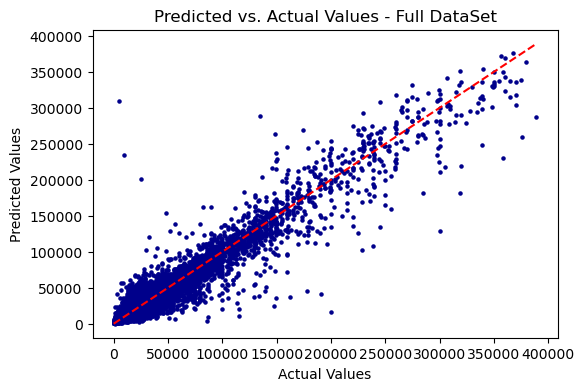

In [7]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, s=5, color='darkblue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values - Full DataSet')
plt.show()

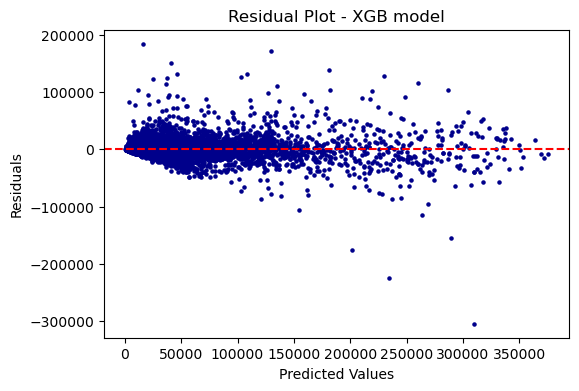

In [8]:
# Plot Residuals
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, s = 5, color='darkblue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - XGB model')
plt.show()

In [10]:
#  Now we will use the scaled version of Modell_encoded for the merge
# Prepare DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual Price': y_test,               
    'Predicted Price': y_pred,
    'Residuals':y_test-y_pred,
    'Abs_residuals':abs(y_test-y_pred),
    'Year' :2024 -  X_test['age'],
    'Power': X_test['power_ps'],
    'Mileage': X_test['mileage_in_km'],
    'Modell_encoded': X_test['Modell_encoded'],
    'Age':X_test['age'],
    'Fuel':X_test['fuel_consumption_l_100km']
})

# Step 3: Extract the original 'model' names from df_clean, including the scaled Modell_encoded
models_df = df_clean[['Modell_encoded', 'model', 'brand']].drop_duplicates()  # Ensure unique Modell_encoded_scaled values

# Step 4: Merge the comparison DataFrame with models_df based on 'Modell_encoded_scaled'
final_comparison_df = pd.merge(comparison_df, models_df, on='Modell_encoded', how='left')

# View the final comparison DataFrame
final_comparison_df


,Actual Price,Predicted Price,Residuals,Abs_residuals,Year,Power,Mileage,Modell_encoded,Age,Fuel,model,brand
0,8685.0,13012.257812,-4327.257812,4327.257812,2014.0,150.0,143623.0,21352.507317,10.0,4.5,Skoda Octavia,skoda
1,29990.0,26777.845703,3212.154297,3212.154297,2017.0,190.0,172661.0,23930.188571,7.0,5.8,Mercedes-Benz Vito,mercedes-benz
2,11900.0,14108.957031,-2208.957031,2208.957031,2009.0,306.0,275000.0,35995.277272,15.0,6.9,BMW 740,bmw
3,35980.0,34635.402344,1344.597656,1344.597656,2023.0,150.0,100.0,27979.466908,1.0,6.5,SEAT Ateca,seat
4,4990.0,4750.384766,239.615234,239.615234,2005.0,75.0,30000.0,3234.673082,19.0,6.1,Renault Modus,renault
...,...,...,...,...,...,...,...,...,...,...,...,...
47511,23300.0,21125.623047,2174.376953,2174.376953,2015.0,258.0,175100.0,23632.863071,9.0,6.0,BMW X3,bmw
47512,15980.0,16753.482422,-773.482422,773.482422,2015.0,110.0,54000.0,17472.635914,9.0,5.4,Volkswagen Golf Sportsvan,volkswagen
47513,21995.0,19905.697266,2089.302734,2089.302734,2014.0,184.0,63773.0,17731.760717,10.0,6.0,Mercedes-Benz C 200,mercedes-benz
47514,9990.0,11318.509766,-1328.509766,1328.509766,2016.0,86.0,19000.0,11795.147679,8.0,4.7,Kia Picanto,kia


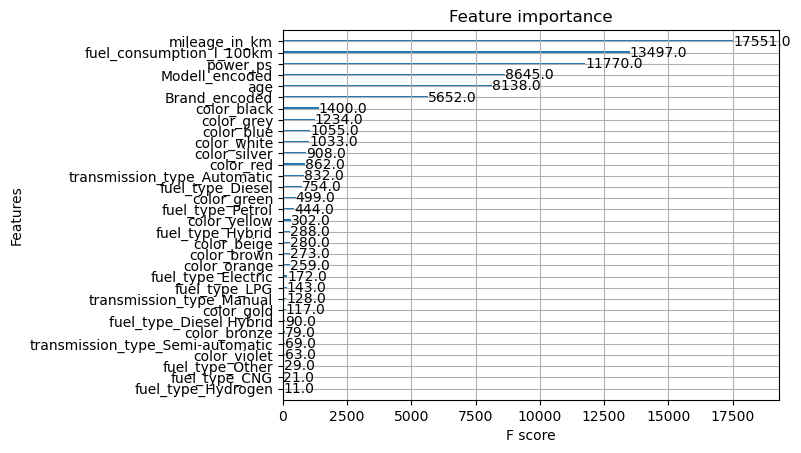

In [83]:
import xgboost as xgb
# Initialize and train the XGBRegressor
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=10, gamma=0, learning_rate = 0.1, reg_alpha = 0.5, reg_lambda = 5)
xgb_model.fit(X_train, y_train)

# Plot feature importance
plot_importance(xgb_model)
plt.show()

SHAP Values for XGBRegressor model


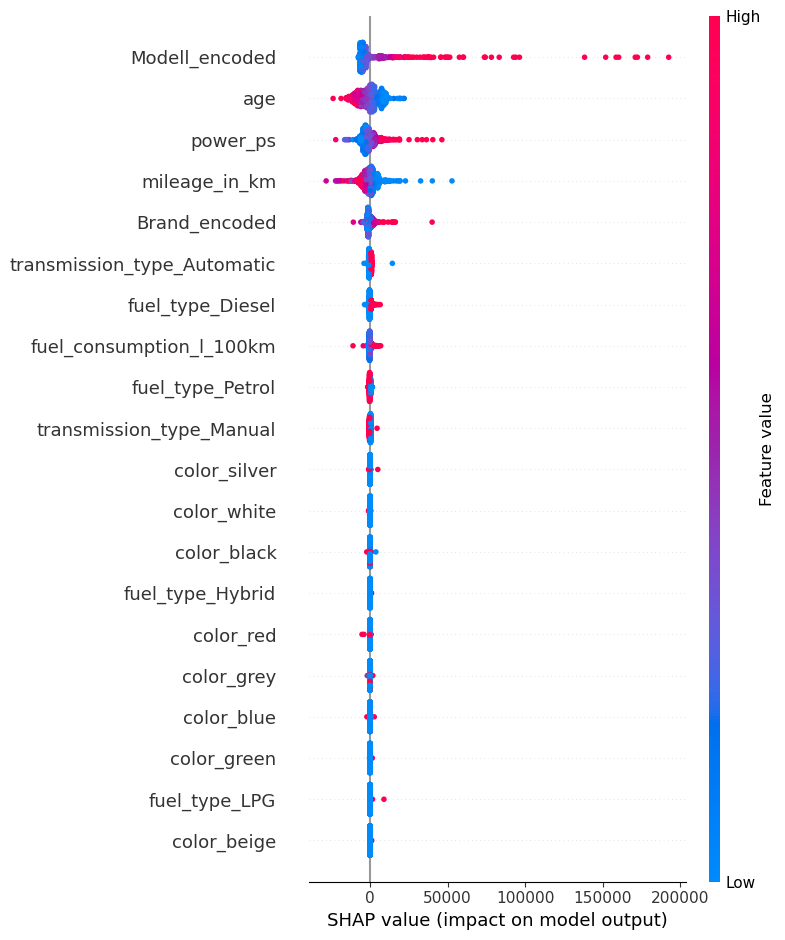

In [84]:
import xgboost as xgb


# Initialize and train the XGBRegressor
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=10, gamma=0, learning_rate=0.1, reg_alpha=0.5, reg_lambda=5)
xgb_model.fit(X_train, y_train)

# Sample the test data to speed up SHAP calculations (optional)
X_test_sampled = shap.sample(X_test, 1000)

# Use TreeExplainer for tree-based models like XGBRegressor
explainer = shap.TreeExplainer(xgb_model)

# Get SHAP values for the sampled data
shap_values = explainer.shap_values(X_test_sampled)

# Print SHAP values summary
print('SHAP Values for XGBRegressor model')

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test_sampled)

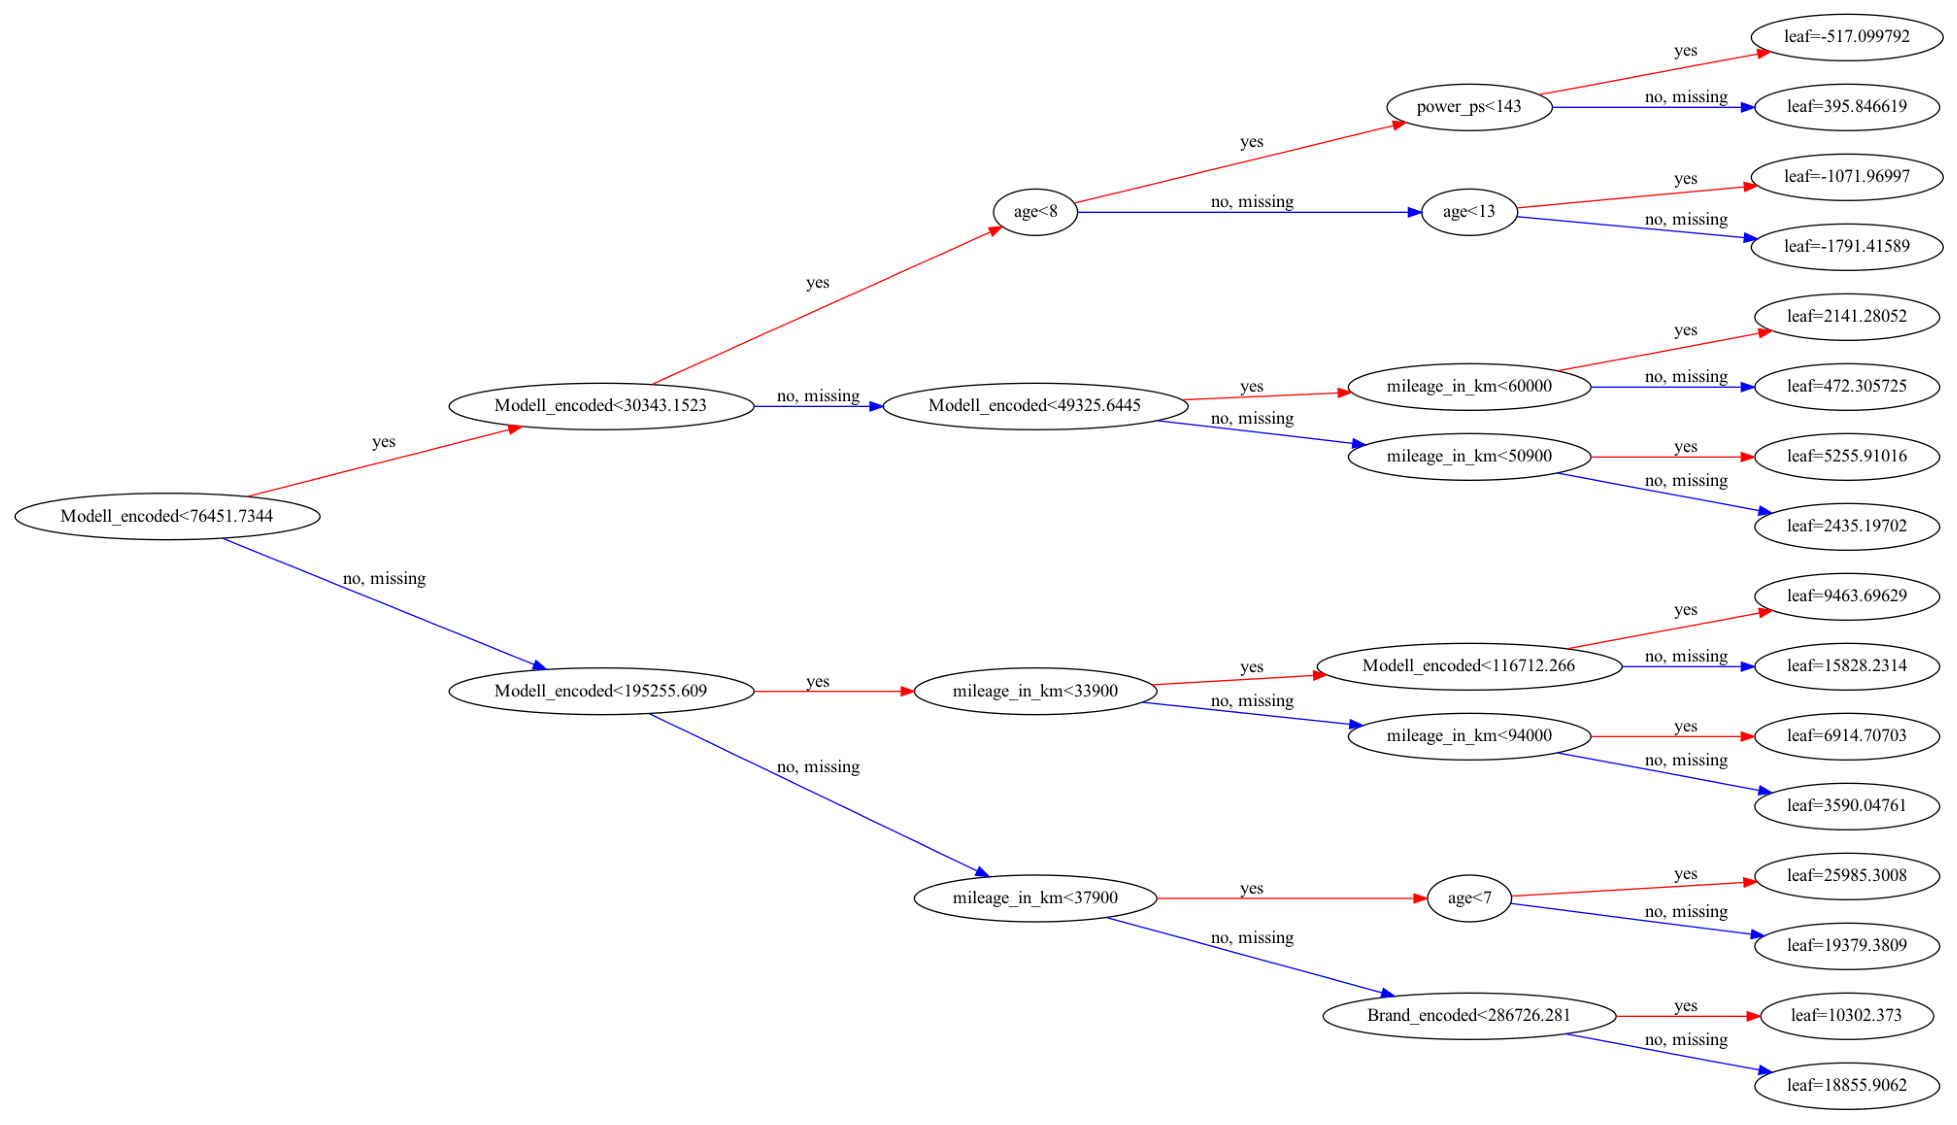

In [170]:
from xgboost import plot_tree

# Train an XGBRegressor
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=4, gamma=0, learning_rate=0.1, reg_alpha=0.5, reg_lambda=5)
xgb_model.fit(X_train, y_train)

# Plot a single tree from the model with a larger figure size and readable font
fig, ax = plt.subplots(figsize=(25, 15))  # Increase figure size for readability
plot_tree(xgb_model, num_trees=0, rankdir="LR", ax=ax)
plt.rcParams.update({'font.size': 16})  # Adjust font size if needed
plt.show()

## Analysis of Errors:

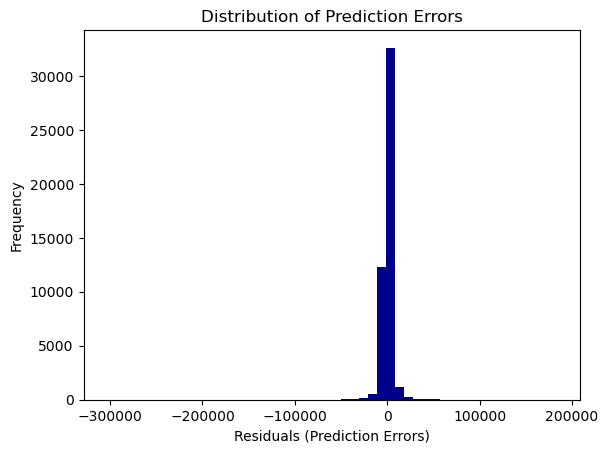

In [11]:
# Plot histogram of residuals
plt.hist(final_comparison_df['Residuals'], bins=50, color='darkblue')
plt.xlabel('Residuals (Prediction Errors)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

In [12]:
#First: view the highest values for error prediciton
final_comparison_df.sort_values(by='Residuals').head(20)

,Actual Price,Predicted Price,Residuals,Abs_residuals,Year,Power,Mileage,Modell_encoded,Age,Fuel,model,brand
46871,5499.0,309751.656250,-304252.656250,304252.656250,2008.0,625.0,12453.0,162020.831212,16.0,14.5,Mercedes-Benz SLR,mercedes-benz
37298,9500.0,234194.890625,-224694.890625,224694.890625,2007.0,650.0,46300.0,162020.831212,17.0,14.5,Mercedes-Benz SLR,mercedes-benz
23535,24990.0,201197.875000,-176207.875000,176207.875000,2018.0,585.0,21600.0,195424.454381,6.0,13.1,Mercedes-Benz G 63 AMG,mercedes-benz
41575,135000.0,289056.375000,-154056.375000,154056.375000,2006.0,579.0,7000.0,129725.812040,18.0,21.5,Lamborghini Murciélago,lamborghini
41560,149000.0,263870.750000,-114870.750000,114870.750000,2022.0,528.0,62.0,177638.396857,2.0,10.9,Bentley Flying Spur,bentley
31697,48500.0,154480.546875,-105980.546875,105980.546875,2016.0,476.0,33423.0,130226.361345,8.0,12.4,Porsche 911,porsche
6442,174450.0,269156.437500,-94706.437500,94706.437500,2022.0,650.0,6250.0,191615.125846,2.0,11.1,Porsche 992,porsche
5304,149800.0,237400.359375,-87600.359375,87600.359375,2022.0,510.0,2200.0,191615.125846,2.0,12.4,Porsche 992,porsche
39898,32990.0,120417.187500,-87427.187500,87427.187500,2018.0,421.0,41000.0,116712.262501,6.0,11.5,Mercedes-Benz G 500,mercedes-benz
17267,159900.0,245195.562500,-85295.562500,85295.562500,2021.0,551.0,7000.0,176198.057280,3.0,7.0,Aston Martin DBX,aston-martin


In [13]:
final_comparison_df.sort_values(by='Residuals').tail(20)

,Actual Price,Predicted Price,Residuals,Abs_residuals,Year,Power,Mileage,Modell_encoded,Age,Fuel,model,brand
32116,115890.0,20481.546875,95408.453125,95408.453125,2015.0,204.0,162000.0,22014.278177,9.0,4.5,Mercedes-Benz C 250,mercedes-benz
35009,254991.0,159159.031250,95831.968750,95831.968750,2017.0,581.0,20000.0,130226.361345,7.0,9.1,Porsche 911,porsche
25309,224800.0,126715.007812,98084.992188,98084.992188,2023.0,503.0,9000.0,70108.073977,1.0,11.3,Mercedes-Benz S 580,mercedes-benz
11334,319963.0,219066.687500,100896.312500,100896.312500,2013.0,571.0,18500.0,245042.017255,11.0,13.2,Mercedes-Benz SLS,mercedes-benz
40927,389000.0,286542.812500,102457.187500,102457.187500,2014.0,605.0,15659.0,250796.662085,10.0,13.3,Ferrari 458,ferrari
27726,285000.0,181703.250000,103296.750000,103296.750000,2018.0,446.0,310.0,113987.316378,6.0,13.8,Aston Martin V8,aston-martin
14857,115000.0,11303.149414,103696.850586,103696.850586,2006.0,306.0,267000.0,25431.808539,18.0,11.6,Mercedes-Benz GL 420,mercedes-benz
12162,245000.0,134880.140625,110119.859375,110119.859375,2016.0,581.0,70000.0,130226.361345,8.0,9.1,Porsche 911,porsche
7414,149900.0,36328.230469,113571.769531,113571.769531,2016.0,190.0,185000.0,51011.235632,8.0,6.0,Mercedes-Benz V 250,mercedes-benz
28323,375990.0,260152.046875,115837.953125,115837.953125,2022.0,585.0,9900.0,195424.454381,2.0,18.1,Mercedes-Benz G 63 AMG,mercedes-benz


In [14]:
final_comparison_df.sort_values(by='Residuals').tail(20)

,Actual Price,Predicted Price,Residuals,Abs_residuals,Year,Power,Mileage,Modell_encoded,Age,Fuel,model,brand
32116,115890.0,20481.546875,95408.453125,95408.453125,2015.0,204.0,162000.0,22014.278177,9.0,4.5,Mercedes-Benz C 250,mercedes-benz
35009,254991.0,159159.031250,95831.968750,95831.968750,2017.0,581.0,20000.0,130226.361345,7.0,9.1,Porsche 911,porsche
25309,224800.0,126715.007812,98084.992188,98084.992188,2023.0,503.0,9000.0,70108.073977,1.0,11.3,Mercedes-Benz S 580,mercedes-benz
11334,319963.0,219066.687500,100896.312500,100896.312500,2013.0,571.0,18500.0,245042.017255,11.0,13.2,Mercedes-Benz SLS,mercedes-benz
40927,389000.0,286542.812500,102457.187500,102457.187500,2014.0,605.0,15659.0,250796.662085,10.0,13.3,Ferrari 458,ferrari
27726,285000.0,181703.250000,103296.750000,103296.750000,2018.0,446.0,310.0,113987.316378,6.0,13.8,Aston Martin V8,aston-martin
14857,115000.0,11303.149414,103696.850586,103696.850586,2006.0,306.0,267000.0,25431.808539,18.0,11.6,Mercedes-Benz GL 420,mercedes-benz
12162,245000.0,134880.140625,110119.859375,110119.859375,2016.0,581.0,70000.0,130226.361345,8.0,9.1,Porsche 911,porsche
7414,149900.0,36328.230469,113571.769531,113571.769531,2016.0,190.0,185000.0,51011.235632,8.0,6.0,Mercedes-Benz V 250,mercedes-benz
28323,375990.0,260152.046875,115837.953125,115837.953125,2022.0,585.0,9900.0,195424.454381,2.0,18.1,Mercedes-Benz G 63 AMG,mercedes-benz


In [15]:
final_comparison_df.sort_values(by='Abs_residuals').head(20)

,Actual Price,Predicted Price,Residuals,Abs_residuals,Year,Power,Mileage,Modell_encoded,Age,Fuel,model,brand
46105,8500.0,8499.995117,0.004883,0.004883,2006.0,163.0,143122.0,22105.985007,18.0,8.2,Audi TT,audi
29515,6990.0,6990.059570,-0.059570,0.059570,2011.0,120.0,112500.0,6190.252682,13.0,6.1,Opel Meriva,opel
10971,13990.0,13990.062500,-0.062500,0.062500,2015.0,105.0,85100.0,9972.500162,9.0,6.0,Volkswagen Polo,volkswagen
39472,46598.0,46598.148438,-0.148438,0.148438,2023.0,200.0,12.0,21352.507317,1.0,5.4,Skoda Octavia,skoda
24014,31477.0,31476.839844,0.160156,0.160156,2017.0,265.0,85900.0,26002.665150,7.0,5.3,BMW 530,bmw
7314,12000.0,12000.196289,-0.196289,0.196289,2013.0,163.0,142200.0,23339.566867,11.0,6.2,Ford Kuga,ford
30775,20197.0,20196.763672,0.236328,0.236328,2022.0,72.0,10.0,13021.740883,2.0,5.0,Toyota Aygo,toyota
1081,18999.0,18999.238281,-0.238281,0.238281,2009.0,224.0,86993.0,19159.833137,15.0,7.9,Mercedes-Benz GLK 320,mercedes-benz
28034,60100.0,60099.644531,0.355469,0.355469,2021.0,190.0,29450.0,51011.235632,3.0,6.4,Mercedes-Benz V 250,mercedes-benz
24524,10988.0,10987.633789,0.366211,0.366211,2013.0,101.0,135900.0,20880.403624,11.0,7.0,Ford Transit,ford


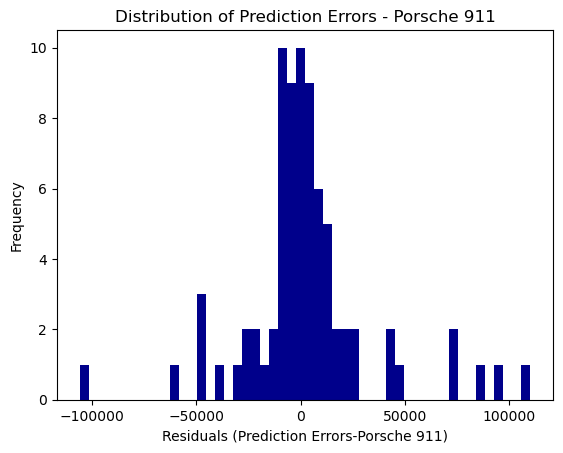

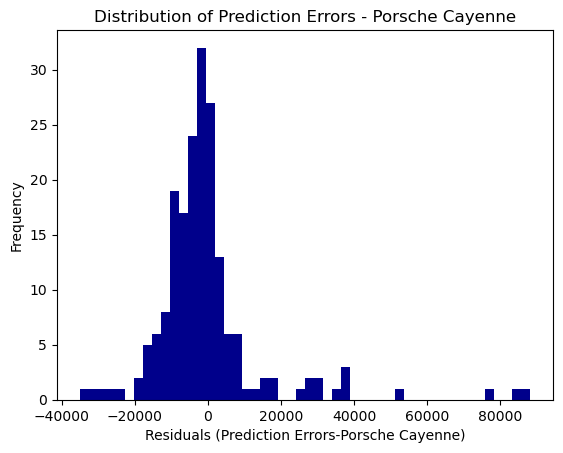

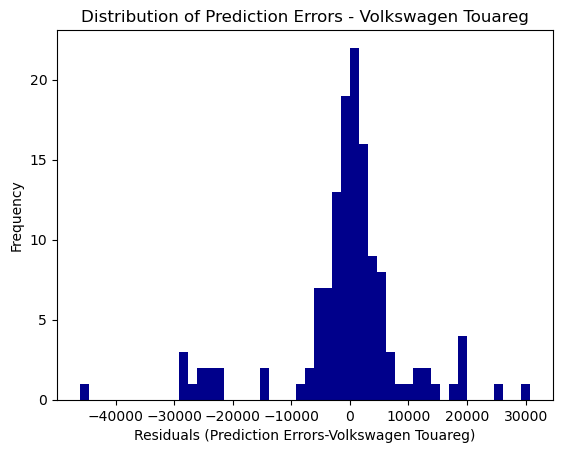

In [55]:
# Plot histogram of residuals for Porsche 911
plt.hist(final_comparison_df['Residuals'].loc[final_comparison_df['model']=='Porsche 911'], bins=50, color='darkblue')
plt.xlabel('Residuals (Prediction Errors-Porsche 911)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors - Porsche 911')
plt.show()
# Plot histogram of residuals for Porsche Cayenne
plt.hist(final_comparison_df['Residuals'].loc[final_comparison_df['model']=='Porsche Cayenne'], bins=50, color='darkblue')
plt.xlabel('Residuals (Prediction Errors-Porsche Cayenne)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors - Porsche Cayenne')
plt.show()

# Plot histogram of residuals for Porsche Cayenne
plt.hist(final_comparison_df['Residuals'].loc[final_comparison_df['model']=='Volkswagen Touareg'], bins=50, color='darkblue')
plt.xlabel('Residuals (Prediction Errors-Volkswagen Touareg)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors - Volkswagen Touareg')
plt.show()

In [17]:
outlier_threshold = 2.5 * np.std(residuals)  # Set a threshold for residuals
outliers = final_comparison_df[abs(final_comparison_df['Residuals']) > outlier_threshold]
outliers.shape

(999, 12)

  price_range  count
0        >50k    662
1     20k-30k     86
2     40k-50k     85
3     30k-40k     83
4     10k-20k     67
5        <10k     16


/var/folders/bg/6h6fxpzx7_v6jgvd0c31r_7m0000gn/T/ipykernel_42160/963563215.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['price_range'] = pd.cut(outliers['Actual Price'], bins=bins, labels=labels)


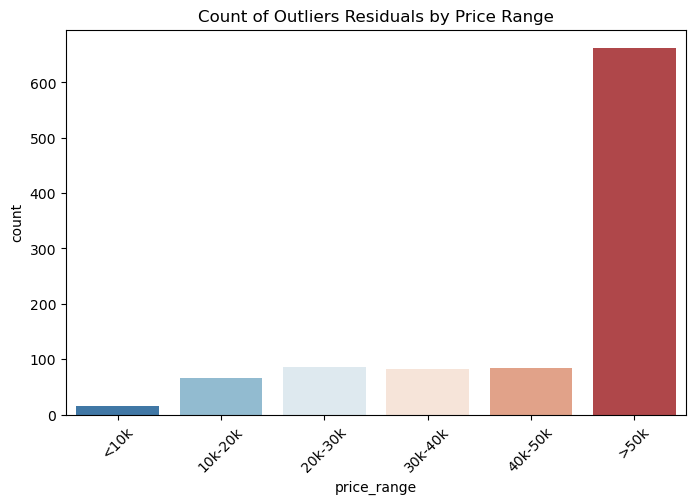

In [20]:
# Define price bins
bins = [0, 10000, 20000, 30000, 40000, 50000, float('inf')]
labels = ['<10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k', '>50k']

# Create a new column for price ranges
outliers['price_range'] = pd.cut(outliers['Actual Price'], bins=bins, labels=labels)

# Group by price range
price_range_distribution = outliers['price_range'].value_counts().reset_index()
price_range_distribution.columns = ['price_range', 'count']

# Display the distribution
print(price_range_distribution)
# Visualize the price ranges
plt.figure(figsize=(8, 5))
sns.barplot(data=price_range_distribution, x='price_range', y='count', palette='RdBu_r')
plt.title('Count of Outliers Residuals by Price Range')
plt.xticks(rotation=45)
plt.show()

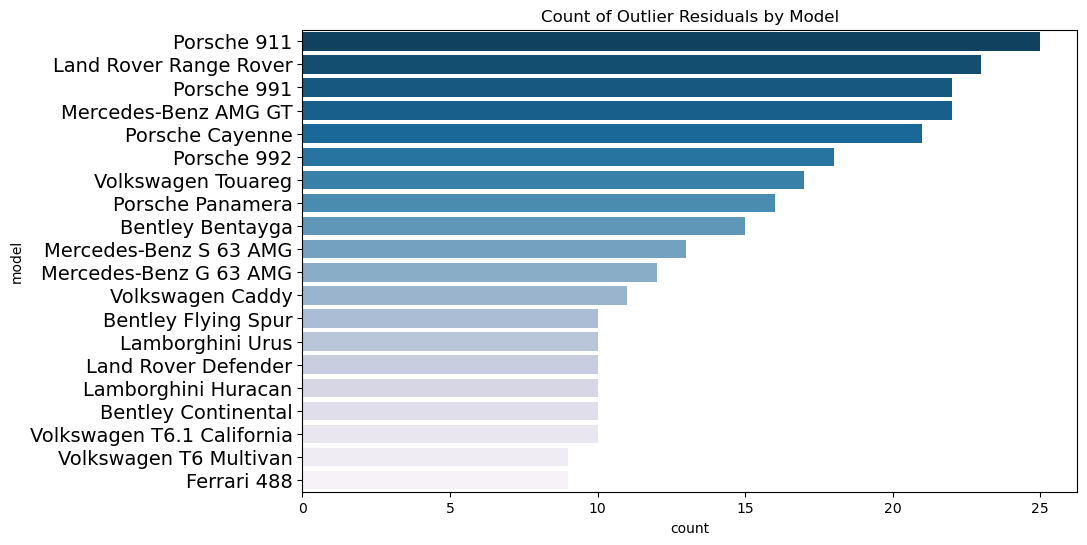

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(data=outliers, y='model', order=outliers['model'].value_counts().head(20).index, palette='PuBu_r')
plt.title('Count of Outlier Residuals by Model')
plt.yticks(fontsize=14)

plt.show()

In [24]:
outlier_threshold = 2.5 * np.std(residuals)  # Set a threshold for residuals
outliers = final_comparison_df[abs(final_comparison_df['Residuals']) > outlier_threshold]
outliers.shape

(999, 12)

In [25]:
#I will try to define the outliers for the price for every brand:


df = pd.read_csv("auto_data_cleaned_16_09_2024.csv")

def detect_outliers_iqr(group):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = group['price_in_euro'].quantile(0.25)
    Q3 = group['price_in_euro'].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter prices outside the bounds
    outliers = group[(group['price_in_euro'] < lower_bound) | (group['price_in_euro'] > upper_bound)]
    
    return outliers



outliers_iqr = df.groupby('model', group_keys=False).apply(detect_outliers_iqr).reset_index(drop=True)

# Keep the model and other relevant columns (if needed)
outliers_iqr['Actual Price'] = outliers_iqr['price_in_euro']

# Display the outliers DataFrame
print(outliers_iqr)



           brand           model  color    year  price_in_euro  power_ps  \
0     alfa-romeo      Alfa Romeo   grey  2022.0        39900.0     131.0   
1     alfa-romeo      Alfa Romeo   grey  2023.0        48340.0     131.0   
2     alfa-romeo  Alfa Romeo 147  black  2003.0        17500.0     250.0   
3     alfa-romeo  Alfa Romeo 147  black  2003.0        17999.0     250.0   
4     alfa-romeo  Alfa Romeo 147   blue  2004.0        24990.0     250.0   
...          ...             ...    ...     ...            ...       ...   
5297       smart    smart forTwo  white  2019.0        29999.0     121.0   
5298       smart    smart forTwo  white  2019.0        29999.0     122.0   
5299       smart    smart forTwo  white  2019.0        34999.0     122.0   
5300       smart    smart forTwo  white  2019.0        35800.0     122.0   
5301       smart  smart roadster   blue  2006.0        17700.0      90.0   

     transmission_type fuel_type  fuel_consumption_l_100km  mileage_in_km  \
0         

In [26]:
# Merge the two DataFrames on brand and price
matches = pd.merge(outliers, outliers_iqr, on=['model', 'Actual Price'])

# Check the matches
print("Matching Outliers:")
matches.shape

Matching Outliers:


(279, 23)

In [27]:
#I want to get insights for those error which are coming not form the price outliers

# Merge the DataFrames to find matches, including the 'brand' column from `outliers`
merged = outliers.merge(matches[['model', 'Actual Price']], on=['model', 'Actual Price'], how='left', indicator=True)

# Now, retain the 'brand' column in the resulting DataFrame
remaining_outliers = merged[merged['_merge'] == 'left_only']
remaining_outliers.shape


(744, 13)

In [28]:
# Grouping by brand and model
grouped_by_brand_model = remaining_outliers.groupby(['brand']).size().reset_index(name='count')

# Display the grouped results
print(grouped_by_brand_model.sort_values(by='count', ascending=False))

            brand  count
21  mercedes-benz    167
26        porsche    107
2            audi     82
32     volkswagen     49
18     land-rover     48
3         bentley     46
4             bmw     44
9         ferrari     38
17    lamborghini     25
1    aston-martin     25
11           ford     18
19       maserati     16
15           jeep      8
31         toyota      7
33          volvo      7
8           dodge      7
14         jaguar      6
23         nissan      5
5        cadillac      5
25        peugeot      5
27        renault      4
30          skoda      3
24           opel      3
10           fiat      3
12        hyundai      3
0      alfa-romeo      3
16            kia      2
7         citroen      2
22     mitsubishi      1
20          mazda      1
28          rover      1
29           seat      1
6       chevrolet      1
13       infiniti      1


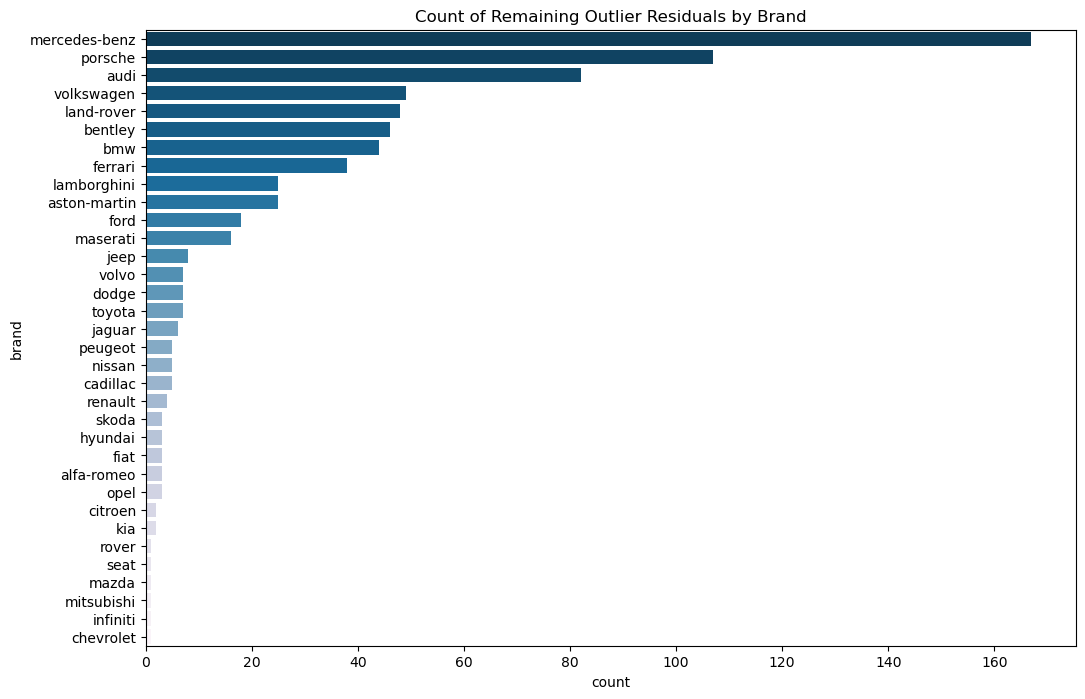

In [30]:
plt.figure(figsize=(12, 8))
sns.countplot(data=remaining_outliers, y='brand', order=remaining_outliers['brand'].value_counts().index, palette='PuBu_r')
plt.title('Count of Remaining Outlier Residuals by Brand')

plt.show()

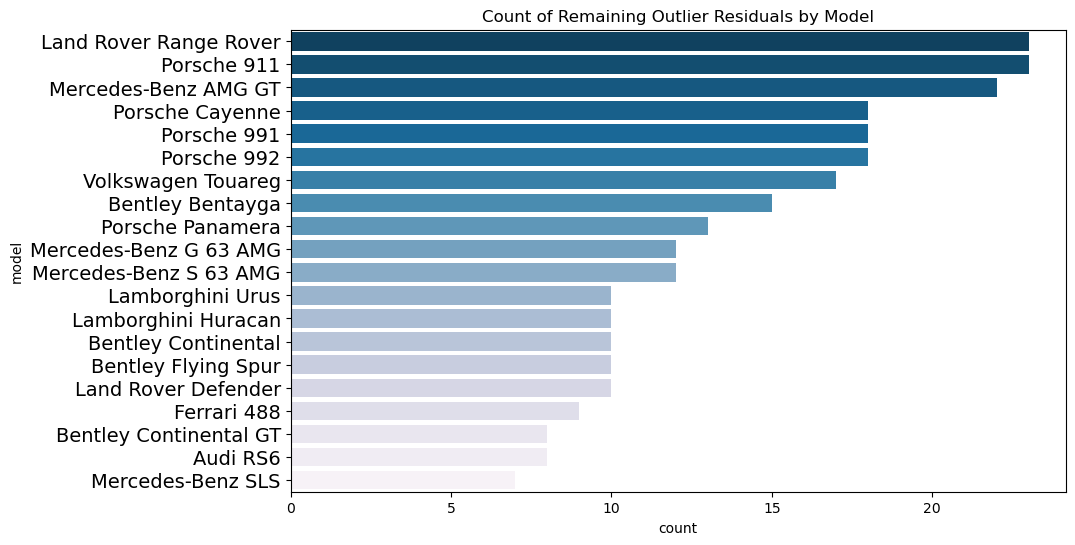

In [32]:
plt.figure(figsize=(10, 6))
sns.countplot(data=remaining_outliers, y='model', order=remaining_outliers['model'].value_counts().head(20).index, palette='PuBu_r')
plt.title('Count of Remaining Outlier Residuals by Model')
plt.yticks(fontsize=14)
plt.show()

  price_range  count
0        >50k    489
1     20k-30k     76
2     10k-20k     57
3     40k-50k     57
4     30k-40k     52
5        <10k     13


/var/folders/bg/6h6fxpzx7_v6jgvd0c31r_7m0000gn/T/ipykernel_42160/633609009.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_outliers['price_range'] = pd.cut(remaining_outliers['Actual Price'], bins=bins, labels=labels)


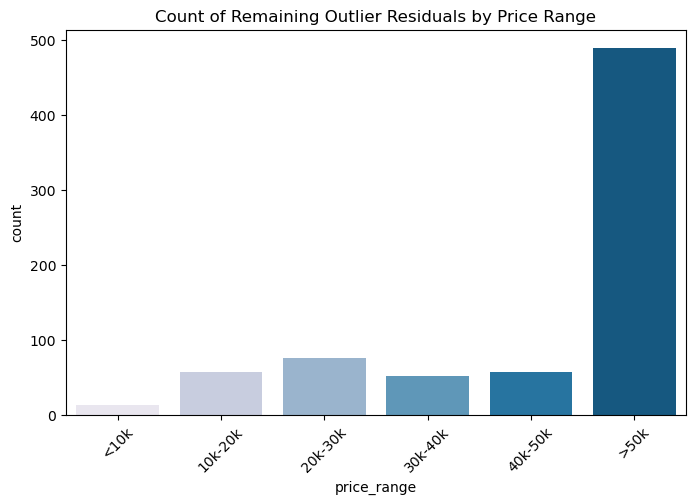

In [33]:
# Define price bins
bins = [0, 10000, 20000, 30000, 40000, 50000, float('inf')]
labels = ['<10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k', '>50k']

# Create a new column for price ranges
remaining_outliers['price_range'] = pd.cut(remaining_outliers['Actual Price'], bins=bins, labels=labels)

# Group by price range
price_range_distribution = remaining_outliers['price_range'].value_counts().reset_index()
price_range_distribution.columns = ['price_range', 'count']

# Display the distribution
print(price_range_distribution)
# Visualize the price ranges
plt.figure(figsize=(8, 5))
sns.barplot(data=price_range_distribution, x='price_range', y='count', palette='PuBu')
plt.title('Count of Remaining Outlier Residuals by Price Range')
plt.xticks(rotation=45)
plt.show()

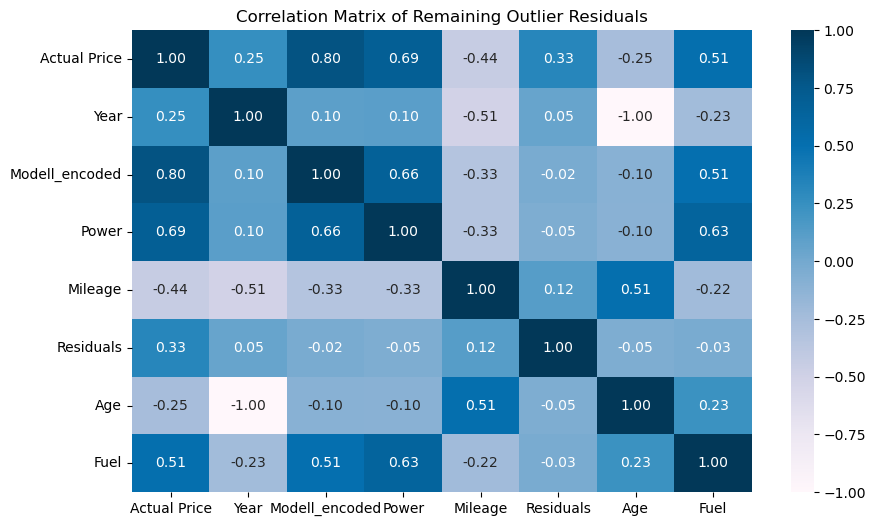

In [35]:

# Calculate correlation matrix
correlation_matrix = remaining_outliers[['Actual Price', 'Year', 'Modell_encoded', 'Power','Mileage','Residuals', 'Age', 'Fuel']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='PuBu', fmt='.2f')
plt.title('Correlation Matrix of Remaining Outlier Residuals')
plt.show()

In [36]:
from sklearn.preprocessing import StandardScaler

# Assuming `remaining_outliers` is your DataFrame of outlier residuals
features = remaining_outliers[['Actual Price', 'Year', 'Modell_encoded', 'Power','Mileage','Residuals', 'Age', 'Fuel']]
  # Select relevant features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

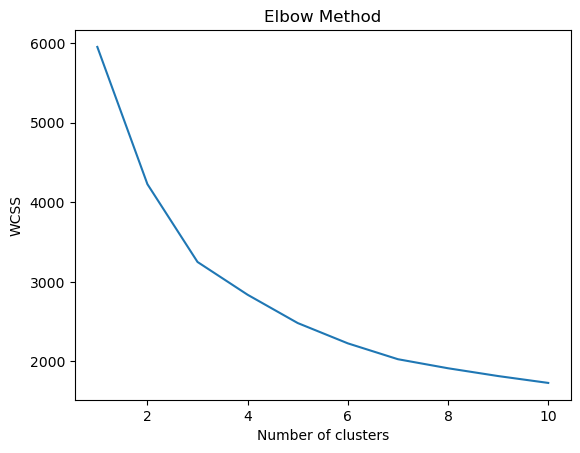

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [41]:
optimal_clusters = 3 # Replace with the optimal number from your analysis
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(scaled_features)

# Add cluster labels to your DataFrame
remaining_outliers['cluster'] = kmeans.labels_

/Users/solozobovavaleria/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/bg/6h6fxpzx7_v6jgvd0c31r_7m0000gn/T/ipykernel_42160/3660564894.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_outliers['cluster'] = kmeans.labels_


In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)  # You can change to n_components=3 for 3D visualization
tsne_results = tsne.fit_transform(scaled_features)

# Add the t-SNE results to your DataFrame
remaining_outliers['tsne-2d-one'] = tsne_results[:, 0]
remaining_outliers['tsne-2d-two'] = tsne_results[:, 1]

/var/folders/bg/6h6fxpzx7_v6jgvd0c31r_7m0000gn/T/ipykernel_42160/3574763087.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_outliers['tsne-2d-one'] = tsne_results[:, 0]
/var/folders/bg/6h6fxpzx7_v6jgvd0c31r_7m0000gn/T/ipykernel_42160/3574763087.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_outliers['tsne-2d-two'] = tsne_results[:, 1]


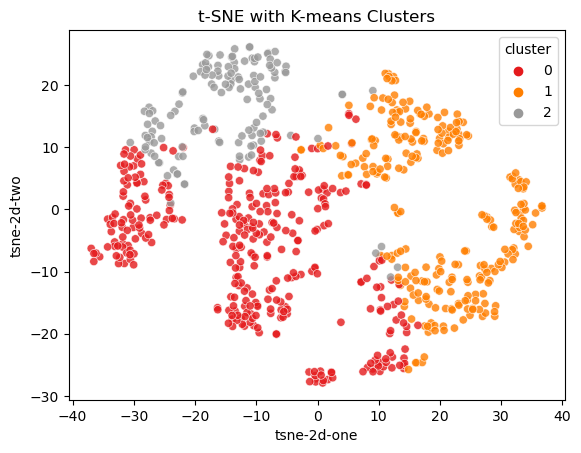

In [46]:
# Assuming you have already created K-means clusters
sns.scatterplot(
    x='tsne-2d-one', 
    y='tsne-2d-two',
    hue='cluster',  # Visualize K-means clusters
    palette=sns.color_palette('Set1', as_cmap=True),
    data=remaining_outliers,
    legend='full',
    alpha=0.8
)
plt.title('t-SNE with K-means Clusters')
plt.show()

In [47]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # You can adjust perplexity
tsne_results = tsne.fit_transform(scaled_features)
# Example: Summarize the features by cluster
cluster_summary = remaining_outliers.groupby('cluster').agg({
    'Actual Price': ['mean', 'median', 'std','min', 'max'],
    'Mileage': ['mean', 'median', 'std', 'min','max'],
    'Power': ['mean', 'median', 'min', 'max'],
    'Residuals':['mean', 'median', 'min', 'max'],
    'Year': ['mean', 'median', 'min', 'max'],
    
})
cluster_summary

Actual Price                                             \
                  mean    median           std      min       max   
cluster                                                             
0         58129.210983   49000.0  35789.417575   7980.0  182500.0   
1        203154.196226  193555.0  75587.156617  24990.0  389000.0   
2         57429.045113   42000.0  47357.893673   1450.0  229900.0   

               Mileage                                           ...  Power  \
                  mean   median           std     min       max  ...    min   
cluster                                                          ...          
0         51097.063584  43473.0  44437.053344    10.0  250000.0  ...   75.0   
1         19652.452830  13489.0  19660.581138    10.0   91893.0  ...  349.0   
2        109780.609023  99982.0  68080.335529  7000.0  366000.0  ...   75.0   

                  Residuals                                              \
           max         mean        median            min            max   
cluster                                                                   
0        680.0 -3664.244670 -18276.593750 -105980.546875   88228.289062   
1        850.0  3570.075133  17959.062500 -176207.875000  130902.984375   
2        680.0 -8113.447032 -18576.128906 -304252.656250   77953.107422   

                Year                          
                mean  median     min     max  
cluster                                       
0        2019.104046  2019.0  2013.0  2023.0  
1        2019.513208  2020.0  2010.0  2023.0  
2        2009.000000  2010.0  1996.0  2018.0  

[3 rows x 22 columns]

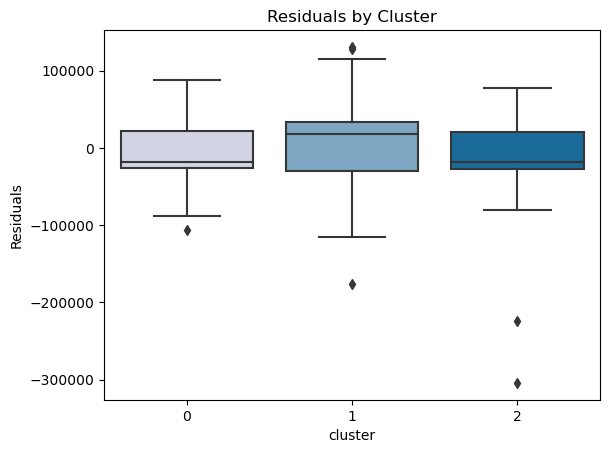

In [48]:
sns.boxplot(x='cluster', y='Residuals', data=remaining_outliers, palette='PuBu')
plt.title('Residuals by Cluster')
plt.show()

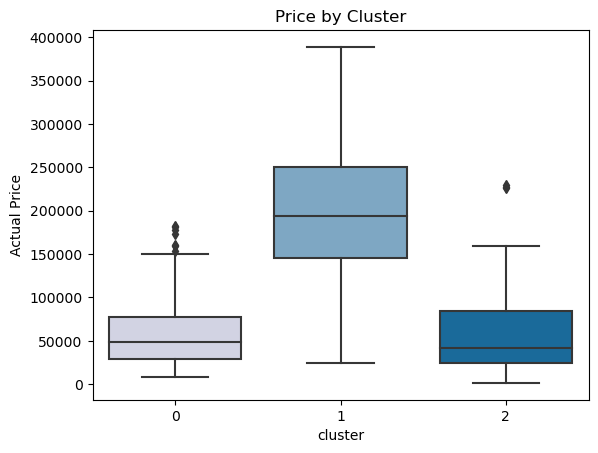

In [49]:
sns.boxplot(x='cluster', y='Actual Price', data=remaining_outliers, palette='PuBu')
plt.title('Price by Cluster')
plt.show()

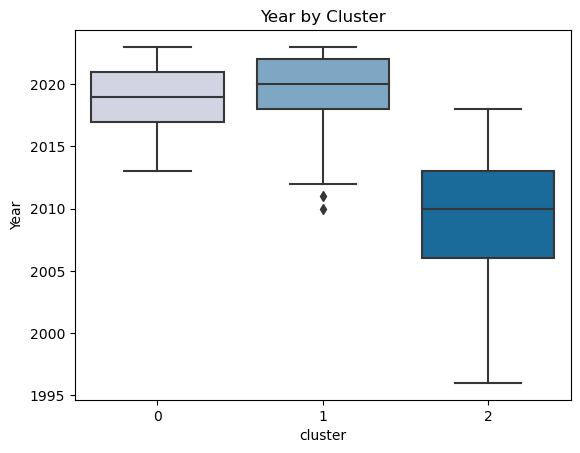

In [50]:
sns.boxplot(x='cluster', y='Year', data=remaining_outliers, palette='PuBu')
plt.title('Year by Cluster')
plt.show()

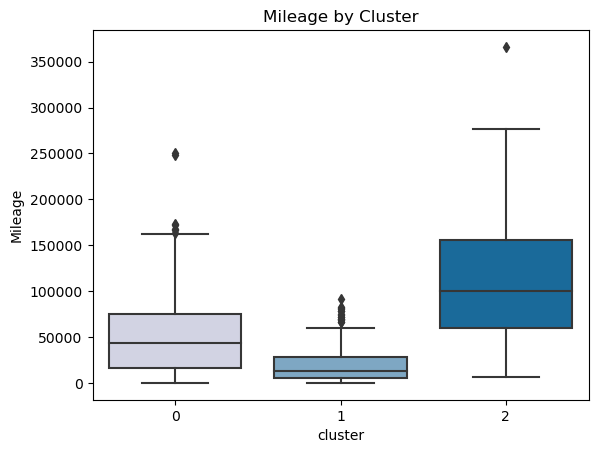

In [51]:
sns.boxplot(x='cluster', y='Mileage', data=remaining_outliers, palette='PuBu')
plt.title('Mileage by Cluster')
plt.show()

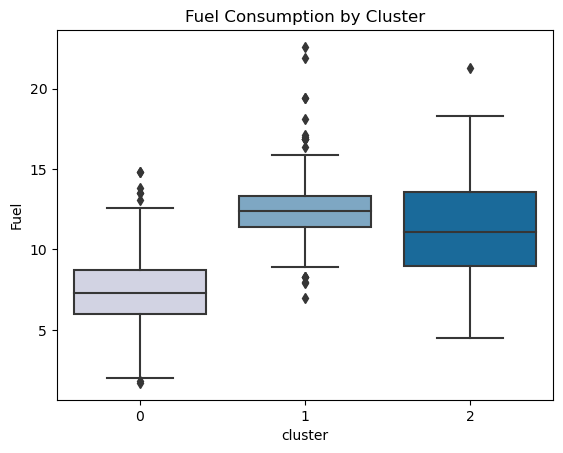

In [52]:
sns.boxplot(x='cluster', y='Fuel', data=remaining_outliers, palette='PuBu')
plt.title('Fuel Consumption by Cluster')
plt.show()

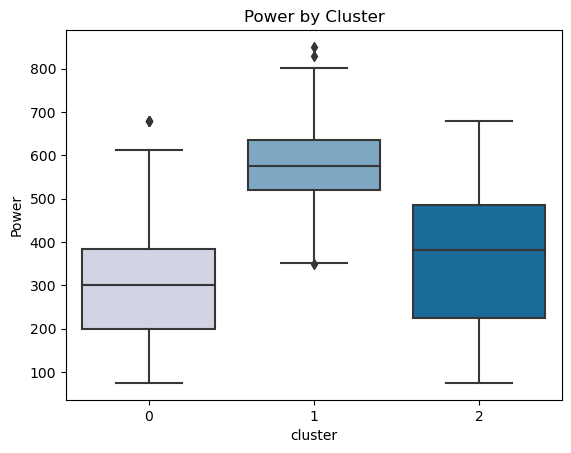

In [53]:
sns.boxplot(x='cluster', y='Power', data=remaining_outliers, palette='PuBu')
plt.title('Power by Cluster')
plt.show()

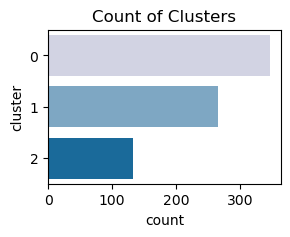

In [54]:
plt.figure(figsize=(3,2))
sns.countplot(data=remaining_outliers, y='cluster', palette='PuBu')
plt.title('Count of Clusters')

plt.show()

## Bonus: test of XGBoost without colors

In [184]:
#cleaned dataset
df = pd.read_csv("auto_data_cleaned_16_09_2024.csv")

# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['year', 'color', 'offer_description' ])

df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type'], dtype='int')

# Remove outliers using Z-score for price and mileage
df_clean = df[(np.abs(stats.zscore(df['price_in_euro'])) <10)]  # 4 is the higher threshold for outliers
df_clean = df_clean[(np.abs(stats.zscore(df_clean['mileage_in_km'])) < 4)]  # Do the same for mileage




In [185]:
# Splitting the data into training and test sets
X = df_clean.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df_clean['price_in_euro']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [186]:
# Initialize the model with default parameters
xgb = XGBRegressor(n_estimators=200, max_depth=10, gamma=0, learning_rate = 0.1, reg_alpha = 0, reg_lambda = 1)
# Train the model
xgb.fit(X_train, y_train)

# : Evaluate the model on the Test Set
y_pred = xgb.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f"Test MAE - full dataset w/o Outliers): {test_mae}")
print(f"Test Set MSE - full dataset w/o Outliers: {mse_test}")
print(f"Test R² - full dataset w/o Outliers: {test_r2}")

# : Evaluate the model on the Train Set
y_pred_train = xgb.predict(X_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)

print(f"Train MAE - full dataset w/o Outliers: {train_mae}")
print(f"Train Set MSE - full dataset w/o Outliers: {mse_train}")
print(f"Train R² - full dataset w/o Outliers: {train_r2}")


Test MAE - full dataset w/o Outliers): 2992.849894689401
Test Set MSE - full dataset w/o Outliers: 47698711.30533586
Test R² - full dataset w/o Outliers: 0.9340192009956599
Train MAE - full dataset w/o Outliers: 2334.342015667973
Train Set MSE - full dataset w/o Outliers: 19033077.85989765
Train R² - full dataset w/o Outliers: 0.9746797024247973


In [187]:
#  Now we will use the scaled version of Modell_encoded for the merge
# Prepare DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual Price': y_test,               
    'Predicted Price': y_pred,
    'Residuals':y_test-y_pred,
    'Abs_residuals':abs(y_test-y_pred),
    'Year' :2024 -  X_test['age'],
    'Power': X_test['power_ps'],
    'Mileage': X_test['mileage_in_km'],
    'Modell_encoded': X_test['Modell_encoded'],
    'Age':X_test['age'],
    'Fuel':X_test['fuel_consumption_l_100km']
})

# Step 3: Extract the original 'model' names from df_clean, including the scaled Modell_encoded
models_df = df_clean[['Modell_encoded', 'model', 'brand']].drop_duplicates()  # Ensure unique Modell_encoded_scaled values

# Step 4: Merge the comparison DataFrame with models_df based on 'Modell_encoded_scaled'
final_comparison_df = pd.merge(comparison_df, models_df, on='Modell_encoded', how='left')

# View the final comparison DataFrame
final_comparison_df


,Actual Price,Predicted Price,Residuals,Abs_residuals,Year,Power,Mileage,Modell_encoded,Age,Fuel,model,brand
0,8685.0,13019.971680,-4334.971680,4334.971680,2014.0,150.0,143623.0,21352.507317,10.0,4.5,Skoda Octavia,skoda
1,29990.0,25676.871094,4313.128906,4313.128906,2017.0,190.0,172661.0,23930.188571,7.0,5.8,Mercedes-Benz Vito,mercedes-benz
2,11900.0,13965.401367,-2065.401367,2065.401367,2009.0,306.0,275000.0,35995.277272,15.0,6.9,BMW 740,bmw
3,35980.0,34208.421875,1771.578125,1771.578125,2023.0,150.0,100.0,27979.466908,1.0,6.5,SEAT Ateca,seat
4,4990.0,4562.211426,427.788574,427.788574,2005.0,75.0,30000.0,3234.673082,19.0,6.1,Renault Modus,renault
...,...,...,...,...,...,...,...,...,...,...,...,...
47511,23300.0,20617.341797,2682.658203,2682.658203,2015.0,258.0,175100.0,23632.863071,9.0,6.0,BMW X3,bmw
47512,15980.0,16437.464844,-457.464844,457.464844,2015.0,110.0,54000.0,17472.635914,9.0,5.4,Volkswagen Golf Sportsvan,volkswagen
47513,21995.0,20861.158203,1133.841797,1133.841797,2014.0,184.0,63773.0,17731.760717,10.0,6.0,Mercedes-Benz C 200,mercedes-benz
47514,9990.0,11342.827148,-1352.827148,1352.827148,2016.0,86.0,19000.0,11795.147679,8.0,4.7,Kia Picanto,kia


In [183]:
outlier_threshold = 2.5 * np.std(residuals)  # Set a threshold for residuals
outliers = final_comparison_df[abs(final_comparison_df['Residuals']) > outlier_threshold]
outliers.shape

(997, 12)